<a href="https://colab.research.google.com/github/GUNAPILLCO/neural_profit/blob/main/2_obtencion_preparacion_exploracion_datos/2_4_1_hipotesis_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2.4.1. Hipótesis 1: Continuación del Momentum Intradía

## 0. Clonamos el repositorio

LINK DE REPOSITORIO: https://github.com/GUNAPILLCO/neural_profit

In [37]:
#Clonamos el repo
!git clone https://github.com/GUNAPILLCO/neural_profit.git

fatal: destination path 'neural_profit' already exists and is not an empty directory.


## 1. Importación de Librerías

In [38]:
import sys
!{sys.executable} -m pip install -q pandas_market_calendars
print("✅ Librería instalada: pandas_market_calendars")

✅ Librería instalada: pandas_market_calendars


In [39]:
# Utilidades generales
from datetime import datetime, timedelta
import os
import glob
import requests
import warnings
warnings.filterwarnings('ignore')

# Manejo y procesamiento de datos
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
# Calendario de mercados
#import pandas_market_calendars as mcal



## 2. Carga del dataset mnq_intraday_data

In [40]:
def load_df_github():
    """
    Función para cargar un archivo Parquet desde una URL de GitHub, procesarlo y devolver un DataFrame.
    """
    # Definir la URL del archivo Parquet en GitHub
    url = 'https://raw.githubusercontent.com/GUNAPILLCO/CEIA-GdP/main/3_Desarrollo/2_obtencion_preparacion_exploracion_datos/mnq_intraday_data.parquet'

    # Descargar el archivo desde la URL
    response = requests.get(url)

    # Verificar si la descarga fue exitosa
    if response.status_code != 200:
        raise Exception(f"Error al descargar el archivo: {response.status_code}")

    # Guardar el archivo descargado en el entorno de Colab
    file_path = '/content/mnq_intraday_data.parquet'
    with open(file_path, 'wb') as f:
        f.write(response.content)

    # Leer el archivo Parquet y cargarlo en un DataFrame
    df = pd.read_parquet(file_path)

    # Asegurar que el índice esté en formato datetime
    df.index = pd.to_datetime(df.index)

    # Crear una nueva columna 'date' con la fecha extraída del índice
    df['date'] = df.index.date

    return df

In [41]:
def load_df():
    """
    Función para cargar un archivo Parquet desde el repositorio clonado
    """
    # Definir la URL del archivo Parquet en GitHub
    df_path = '/content/neural_profit/2_obtencion_preparacion_exploracion_datos/mnq_intraday_data.parquet'

    # Leer el archivo Parquet y cargarlo en un DataFrame
    df = pd.read_parquet(df_path)

    # Asegurar que el índice esté en formato datetime
    df.index = pd.to_datetime(df.index)

    # Crear una nueva columna 'date' con la fecha extraída del índice
    df['date'] = df.index.date

    return df

In [42]:
mnq_intraday=load_df()

mnq_intraday.head(10)

,open,high,low,close,volume,date
datetime,,,,,,
2019-12-23 08:00:00-05:00,8734.00,8734.25,8733.75,8733.75,31,2019-12-23
2019-12-23 08:01:00-05:00,8734.00,8734.25,8733.75,8734.00,16,2019-12-23
2019-12-23 08:02:00-05:00,8734.00,8734.00,8733.25,8733.25,23,2019-12-23
2019-12-23 08:03:00-05:00,8734.25,8734.50,8734.00,8734.00,23,2019-12-23
2019-12-23 08:04:00-05:00,8734.00,8734.00,8733.50,8733.75,12,2019-12-23
2019-12-23 08:05:00-05:00,8733.75,8734.50,8733.25,8733.25,37,2019-12-23
2019-12-23 08:06:00-05:00,8734.50,8734.50,8733.75,8733.75,24,2019-12-23
2019-12-23 08:07:00-05:00,8734.00,8734.00,8733.75,8733.75,8,2019-12-23
2019-12-23 08:08:00-05:00,8734.25,8734.25,8733.25,8733.50,48,2019-12-23


## 3. Hipótesis 1: Continuación del Momentum Intradía

**"Si el precio ha subido de forma constante en los últimos N minutos, es probable que continúe subiendo en los próximos minutos."**
<br><br>
**Justificación técnica:** <br>
Basada en la idea de momentum. Los traders tienden a subirse a la ola cuando ven un movimiento fuerte, generando continuación.
<br><br>
**Alpha Factor sugerido:** <br>Se define un factor de momentum como la diferencia entre los logaritmos del precio de cierre actual y el precio de cierre hace `N` minutos:

$$
\text{momentum}_t^{(N)} = \log(\text{close}_t) - \log(\text{close}_{t-N})
$$

Este valor puede interpretarse como el retorno logarítmico acumulado en los últimos `N` minutos. Valores positivos indican tendencia alcista reciente, mientras que valores negativos reflejan presión bajista.

**Parámetros recomendados para N:**  
- Corto plazo: `N = 5`
- Medio plazo: `N = 15`
- Largo plazo intradía: `N = 30`

**Aplicación:**

Este factor puede utilizarse como variable predictora en modelos supervisados, o directamente para generar señales de trading (ej: entrar en largo cuando Momentum > 0).

## 4. Construcción de alpha factor

In [43]:
# 1. Construir alpha_factor
# Añadimos el momentum para 5, 15 y 30 minutos.
mnq_intraday['momentum_5'] = mnq_intraday.groupby('date')['close'].transform(lambda x: np.log(x) - np.log(x.shift(5)))
mnq_intraday['momentum_15'] = mnq_intraday.groupby('date')['close'].transform(lambda x: np.log(x) - np.log(x.shift(15)))
mnq_intraday['momentum_30'] = mnq_intraday.groupby('date')['close'].transform(lambda x: np.log(x) - np.log(x.shift(30)))

#Esto lo vamos a aplicar por día para evitar "mezclar" información entre jornadas.

# 2. Normalizar el factor
# Para evitar que valores extremos distorsionen la interpretación y para que sea comparable entre días, normalizamos por día (por ejemplo, con z-score):

mnq_intraday['momentum_z_5'] = mnq_intraday.groupby('date')['momentum_5'].transform(lambda x: (x - x.mean()) / x.std())
mnq_intraday['momentum_z_15'] = mnq_intraday.groupby('date')['momentum_15'].transform(lambda x: (x - x.mean()) / x.std())
mnq_intraday['momentum_z_30'] = mnq_intraday.groupby('date')['momentum_30'].transform(lambda x: (x - x.mean()) / x.std())

# 3. Evaluar el poder predictivo
# Usamos una métrica como el Information Coefficient (IC): Correlación entre el valor del alpha factor y el retorno futuro.
# Definimos el retorno futuro:

mnq_intraday['target_return_5'] = mnq_intraday.groupby('date')['close'].transform(lambda x: np.log(x.shift(-5)) - np.log(x))
mnq_intraday['target_return_15'] = mnq_intraday.groupby('date')['close'].transform(lambda x: np.log(x.shift(-15)) - np.log(x))
mnq_intraday['target_return_30'] = mnq_intraday.groupby('date')['close'].transform(lambda x: np.log(x.shift(-30)) - np.log(x))

# 4. Evaluamos el IC por día para cada ventana de tiempo
# Evaluamos la correlación entre el factor y el target

ic_by_day_5 = mnq_intraday.dropna().groupby('date').apply(
    lambda x: x['momentum_z_5'].corr(x['target_return_5']))

ic_by_day_15 = mnq_intraday.dropna().groupby('date').apply(
    lambda x: x['momentum_z_15'].corr(x['target_return_15']))

ic_by_day_30 = mnq_intraday.dropna().groupby('date').apply(
    lambda x: x['momentum_z_30'].corr(x['target_return_30']))

# Promedio del IC para cada ventana
mean_ic_5 = ic_by_day_5.mean()
mean_ic_15 = ic_by_day_15.mean()
mean_ic_30 = ic_by_day_30.mean()

# Mostrar los resultados
print(f"Mean IC (Momentum 5 min):  {mean_ic_5:.4f}")
print(f"Mean IC (Momentum 15 min): {mean_ic_15:.4f}")
print(f"Mean IC (Momentum 30 min): {mean_ic_30:.4f}")

Mean IC (Momentum 5 min):  -0.0278
Mean IC (Momentum 15 min): -0.0536
Mean IC (Momentum 30 min): -0.0991


1. La hipótesis original no se valida.

    - El IC es negativo en todas las ventanas, lo que contradice la idea de "continuación de la tendencia".
    - De hecho: A mayor ventana (N), más negativo se vuelve el IC, lo que indica una mayor probabilidad de reversión cuando el momentum es fuerte.

2. Se sugiere comportamiento de Mean Reversion.

    - Este patrón es típico en mercados de alta frecuencia como MNQ, donde los movimientos rápidos suelen agotarse y dar paso a correcciones.
    - Cuanto más largo el período de momentum (30 minutos), más fuerte la señal de reversión.

### 4.1. Replanteo de hipotesis

Hipótesis alternativa: **Si el precio subió mucho en los últimos N minutos, es probable que revierta (baje).**

In [46]:
# 2. Normalizar el factor (pero invirtiendo el signo)
# Esto transforma la hipótesis en reversión: si subió mucho, va a bajar.

mnq_intraday['momentum_rev_z_5'] = mnq_intraday.groupby('date')['momentum_5'].transform(
    lambda x: -(x - x.mean()) / x.std()
)
mnq_intraday['momentum_rev_z_15'] = mnq_intraday.groupby('date')['momentum_15'].transform(
    lambda x: -(x - x.mean()) / x.std()
)
mnq_intraday['momentum_rev_z_30'] = mnq_intraday.groupby('date')['momentum_30'].transform(
    lambda x: -(x - x.mean()) / x.std()
)

# 4. Evaluamos el IC por día para cada ventana de tiempo
# Evaluamos la correlación entre el factor y el target

ic_by_day_5 = mnq_intraday.dropna().groupby('date').apply(
    lambda x: x['momentum_rev_z_5'].corr(x['target_return_5']))

ic_by_day_15 = mnq_intraday.dropna().groupby('date').apply(
    lambda x: x['momentum_rev_z_15'].corr(x['target_return_15']))

ic_by_day_30 = mnq_intraday.dropna().groupby('date').apply(
    lambda x: x['momentum_rev_z_30'].corr(x['target_return_30']))

# Promedio del IC para cada ventana
mean_ic_5_rev = ic_by_day_5.mean()
mean_ic_15_rev = ic_by_day_15.mean()
mean_ic_30_rev = ic_by_day_30.mean()

# Mostrar los resultados
print(f"Mean IC (Momentum rev 5 min):  {mean_ic_5_rev:.4f}")
print(f"Mean IC (Momentum rev 15 min): {mean_ic_15_rev:.4f}")
print(f"Mean IC (Momentum rev 30 min): {mean_ic_30_rev:.4f}")

Mean IC (Momentum rev 5 min):  0.0278
Mean IC (Momentum rev 15 min): 0.0536
Mean IC (Momentum rev 30 min): 0.0991


Al invertir el signo del factor de momentum, el alpha factor pasa de ser negativo a positivo.

Esto valida la hipótesis alternativa: **Los movimientos de precio recientes tienden a revertir, no a continuar.**

**Conclusión final:**
- Hipótesis 1 original (continuación del momentum) no se valida.
- Se valida la hipótesis alternativa: reversión del momentum intradía.

## 5. Comportamiento del alpha factor por minutos del día

In [26]:
def plot_ic_by_minute(df: pd.DataFrame,
                      factor_5: str,
                      factor_15: str,
                      factor_30: str,
                      target_prefix: str = 'target_return_',
                      date_col: str = 'date'):
    """
    Calcula y grafica el IC por minuto intradía para tres alpha factors,
    mostrando el eje X en formato horario (desde las 08:30 AM).
    """

    df = df.copy()
    df['minute_index'] = df.groupby(date_col).cumcount()

    def compute_ic_by_minute(factor_col, target_col):
        grouped = df[[factor_col, target_col, 'minute_index']].dropna()
        return grouped.groupby('minute_index').apply(lambda x: x[factor_col].corr(x[target_col]))

    # Calcular ICs por minuto
    ic_minute_5 = compute_ic_by_minute(factor_5, f'{target_prefix}5')
    ic_minute_15 = compute_ic_by_minute(factor_15, f'{target_prefix}15')
    ic_minute_30 = compute_ic_by_minute(factor_30, f'{target_prefix}30')

    # Generar etiquetas horarias cada 30 minutos
    xticks = np.arange(0, 451, 30)
    start_time = pd.to_datetime("08:00")
    time_labels = [(start_time + pd.Timedelta(minutes=i)).strftime("%H:%M") for i in xticks]

    # Graficar
    plt.figure(figsize=(15, 6))
    plt.plot(ic_minute_5.index, ic_minute_5, label='IC - 5 min')
    plt.plot(ic_minute_15.index, ic_minute_15, label='IC - 15 min')
    plt.plot(ic_minute_30.index, ic_minute_30, label='IC - 30 min')
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.title('IC por Minuto del Día')
    plt.xlabel('Hora intradía (desde 08:00)')
    plt.ylabel('Information Coefficient (IC)')
    plt.xticks(ticks=xticks, labels=time_labels, rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return ic_minute_5, ic_minute_15, ic_minute_30

In [27]:
def analyze_intraday_ic_extremes(ic_minute_df: pd.DataFrame,
                                 mode: str = 'worst',
                                 top_n: int = 30,
                                 market_open: str = "08:00") -> pd.DataFrame:
    """
    Analiza series de IC minuto a minuto para distintos alpha factors.
    Retorna el IC mínimo, IC máximo, y el promedio de los top_n peores o mejores ICs,
    indicando la hora exacta en la que ocurren los extremos.

    Parámetros:
    - ic_minute_df: DataFrame con columnas = alpha factors, índice = minuto (0 a 450)
    - mode: 'worst' para los peores ICs, 'best' para los mejores ICs
    - top_n: cantidad de valores extremos a promediar
    - market_open: hora de inicio del mercado en formato "HH:MM" (por defecto 08:30)

    Retorna:
    - DataFrame resumen ordenado por el promedio de los ICs extremos
    """
    results = []
    base_time = pd.to_datetime(market_open)

    for col in ic_minute_df.columns:
        series = ic_minute_df[col].dropna()

        if mode == 'worst':
            extreme_vals = series.nsmallest(top_n)
        elif mode == 'best':
            extreme_vals = series.nlargest(top_n)
        else:
            raise ValueError("El parámetro 'mode' debe ser 'worst' o 'best'.")

        extreme_mean = extreme_vals.mean()

        # IC mínimo y su hora
        min_ic = series.min()
        min_minute = series.idxmin()
        min_time = (base_time + pd.Timedelta(minutes=min_minute)).strftime("%H:%M")

        # IC máximo y su hora
        max_ic = series.max()
        max_minute = series.idxmax()
        max_time = (base_time + pd.Timedelta(minutes=max_minute)).strftime("%H:%M")

        results.append({
            'Alpha Factor': col,
            'IC mínimo': min_ic,
            'Hora del IC mínimo': min_time,
            'IC máximo': max_ic,
            'Hora del IC máximo': max_time,
            f'Promedio de los {top_n} {"peores" if mode == "worst" else "mejores"} ICs': extreme_mean
        })

    result_df = pd.DataFrame(results).set_index('Alpha Factor')
    sort_col = result_df.columns[-1]
    result_df = result_df.sort_values(sort_col, ascending=(mode == 'worst'))

    return result_df



### 5.1. Hipotesis original

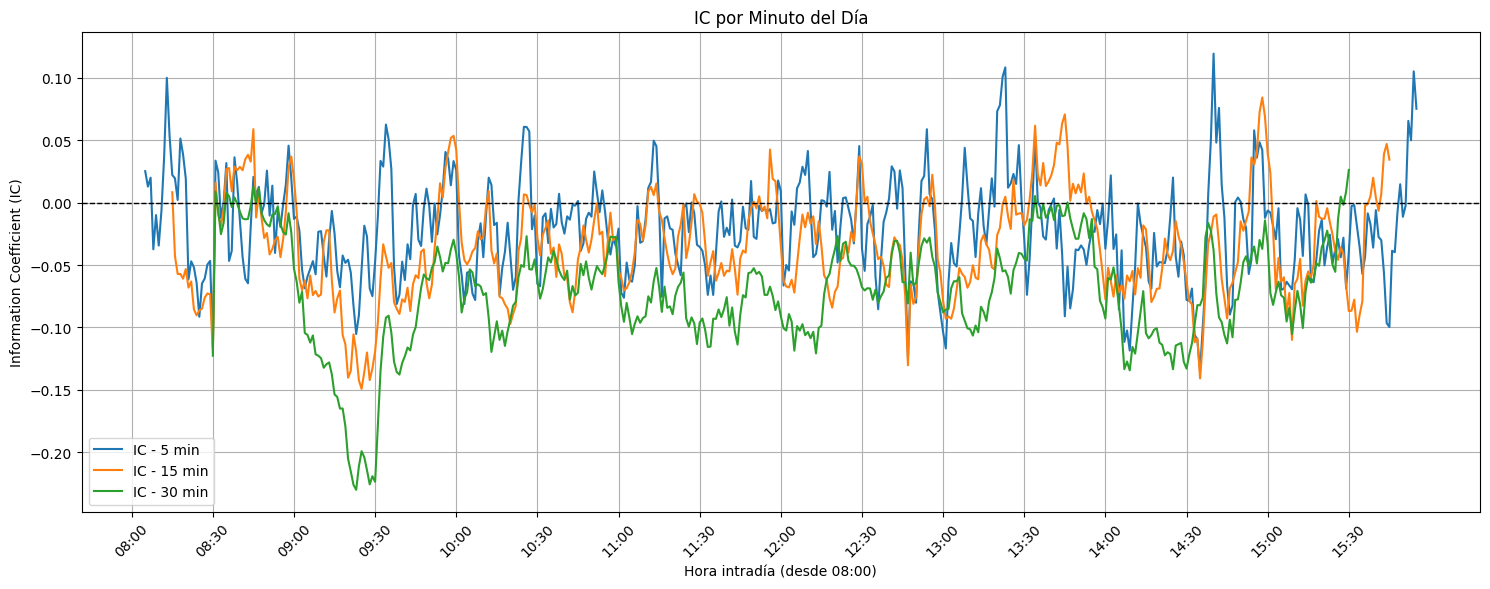

,IC mínimo,Hora del IC mínimo,IC máximo,Hora del IC máximo,Promedio de los 30 peores ICs
Alpha Factor,,,,,
IC_momentum_z_30,-0.230023,09:23,0.026196,15:30,-0.169884
IC_momentum_z_15,-0.149193,09:25,0.084200,14:58,-0.114345
IC_momentum_z_5,-0.135223,14:35,0.119317,14:40,-0.096647


In [28]:
#Hipotesis 1
ic_minute_5, ic_minute_15, ic_minute_30  = plot_ic_by_minute(
    df=mnq_intraday,
    factor_5='momentum_z_5',
    factor_15='momentum_z_15',
    factor_30='momentum_z_30'
)

# Tenemos ic_minute_5, ic_minute_15, ic_minute_30
ic_minute_df = pd.DataFrame({
    'IC_momentum_z_5': ic_minute_5,
    'IC_momentum_z_15': ic_minute_15,
    'IC_momentum_z_30': ic_minute_30
})

# Ver los peores momentos intradía:
analyze_intraday_ic_extremes(ic_minute_df, mode='worst', top_n=30)

La hipótesis de continuación del momentum no se valida: los tres factores muestran IC máximos débiles y promedios negativos sostenidos, indicando que el momentum reciente tiende a revertirse, no a continuar.

### 5.2. Hipotesis reformulada

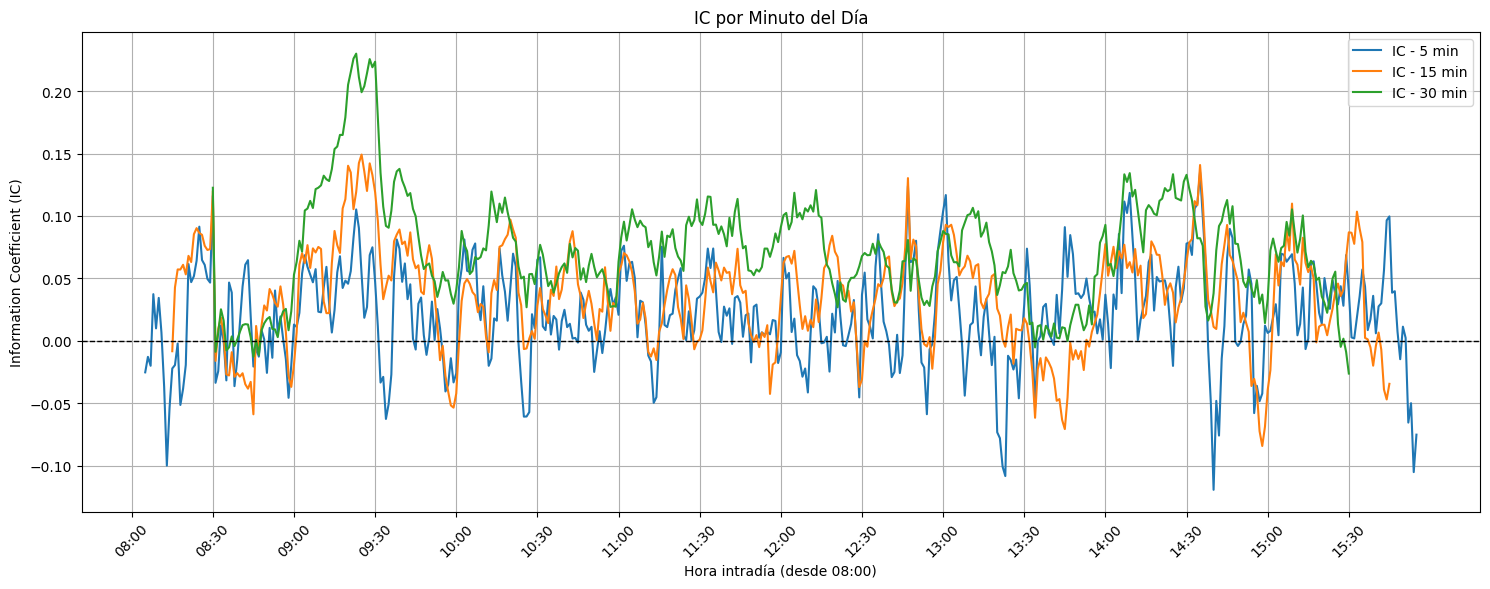

,IC mínimo,Hora del IC mínimo,IC máximo,Hora del IC máximo,Promedio de los 30 mejores ICs
Alpha Factor,,,,,
IC_momentum_rev_30,-0.026196,15:30,0.230023,09:23,0.169884
IC_momentum_rev_15,-0.084200,14:58,0.149193,09:25,0.114345
IC_momentum_rev_5,-0.119317,14:40,0.135223,14:35,0.096647


In [29]:
#Hipotes 1 reformulada
ic_minute_5, ic_minute_15, ic_minute_30  = plot_ic_by_minute(
    df=mnq_intraday,
    factor_5='momentum_rev_z_5',
    factor_15='momentum_rev_z_15',
    factor_30='momentum_rev_z_30'
)

# Tenemos ic_minute_5, ic_minute_15, ic_minute_30
ic_minute_df = pd.DataFrame({
    'IC_momentum_rev_5': ic_minute_5,
    'IC_momentum_rev_15': ic_minute_15,
    'IC_momentum_rev_30': ic_minute_30
})

# Ver los mejores momentos intradía:
analyze_intraday_ic_extremes(ic_minute_df, mode='best', top_n=30)

El mejor alpha factor entre los tres evaluados es **`IC_momentum_rev_30`**, debido a que presenta:

- El **IC máximo más alto**: `0.2231`
- El **promedio más alto de los 30 mejores ICs**: `0.1683`
- Un **IC mínimo poco negativo**: `-0.0343`, lo que indica **bajo riesgo de señales contrarias**

>**Conclusión**: `momentum_rev_z_30` es el alpha factor más efectivo y estable para capturar patrones de **reversión intradía**.


##5.  Agregar el alpha factor a dataset

Es un indicador de reversión intradía.

Tiene más poder predictivo (negativo) en los primeros 90 minutos del día.

Ya está normalizado por día, por lo tanto es comparable entre jornadas.

In [50]:
#Copiamos el dataset limpio
mnq_intraday = load_df()

In [51]:
#Recuerda que nuestro target es el retorno a 30 minutos.
# 2. Definimos el retorno futuro:
#mnq_intraday['target_return_30'] = mnq_intraday.groupby('date')['close'].transform(lambda x: np.log(x.shift(-30)) - np.log(x))
def add_reversion_factor(df: pd.DataFrame,
                          price_col: str = 'close',
                          date_col: str = 'date',
                          window: int = 30) -> pd.DataFrame:
    """
    Agrega una columna 'reversion_media_factor' que es el 'momentum_rev_z_30' al DataFrame, representando el alpha factor
    de reversión a la media basado en el z-score invertido de log-retornos a N minutos.

    Parámetros:
    - df: DataFrame de entrada con columnas de precios y fechas
    - price_col: nombre de la columna de precios (default='close')
    - date_col: nombre de la columna de fecha o jornada (default='date')
    - window: cantidad de minutos para calcular el momentum (default=30)

    Retorna:
    - DataFrame con la columna 'reversion_media_factor' añadida
    """
    df = df.copy()

    def calc_reversal(x):
        m = np.log(x) - np.log(x.shift(window))
        return -(m - m.mean()) / m.std()

    df['reversion_media_factor'] = df.groupby(date_col)[price_col].transform(calc_reversal)
    #df = df.dropna(subset=['momentum_rev_z_30'])

    return df

In [52]:
mnq_intraday = add_reversion_factor(mnq_intraday, window=30)

In [54]:
mnq_intraday.iloc[25:60]

,open,high,low,close,volume,date,reversion_media_factor
datetime,,,,,,,
2019-12-23 08:25:00-05:00,8735.50,8736.00,8735.25,8736.00,32,2019-12-23,NaN
2019-12-23 08:26:00-05:00,8736.00,8736.00,8733.75,8735.00,54,2019-12-23,NaN
2019-12-23 08:27:00-05:00,8735.25,8736.00,8735.00,8736.00,26,2019-12-23,NaN
2019-12-23 08:28:00-05:00,8735.75,8736.00,8735.50,8736.00,19,2019-12-23,NaN
2019-12-23 08:29:00-05:00,8736.25,8736.50,8736.00,8736.50,18,2019-12-23,NaN
2019-12-23 08:30:00-05:00,8736.25,8737.50,8736.25,8737.00,30,2019-12-23,-0.995008
2019-12-23 08:31:00-05:00,8737.00,8737.25,8736.00,8736.50,45,2019-12-23,-0.811209
2019-12-23 08:32:00-05:00,8736.50,8736.75,8735.50,8736.00,73,2019-12-23,-0.872527
2019-12-23 08:33:00-05:00,8736.50,8736.75,8736.00,8736.75,51,2019-12-23,-0.872470


**Interpretación:**

  - Si el precio subió mucho en los últimos 30 minutos, entonces el retorno será alto → el z-score original será positivo → el valor invertido será negativo.

  - Si el precio bajó mucho, el z-score será negativo → el z-score invertido será positivo.

  - Si no hubo mucha variación, el valor estará cerca de 0.

**¿Por qué invertir el signo?**

Porque estoy probando una hipótesis de reversión a la media: si el precio subió mucho, espero que baje (por eso invierto el signo del momentum).

**En resumen:**

Valores negativos indican condiciones de "sobrecompra" (precio subió mucho), donde el modelo podría anticipar una reversión a la baja.